<a href="https://colab.research.google.com/github/Laeti-dev/Project4-Credit-Scoring-Model/blob/EDA/ikusawa_laetitia_1_notebook_0824.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on [this kaggle notebook](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Read-in-Data)

# Imports

In [1]:
# check if the notebook is on colab
import os

if os.path.exists("/content"):
    path = "/content"
    # install dependencies
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install seaborn
    !pip install scikit-learn
else:
    path = "./data"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

# Exploration

There are 9 data files and 1 file explaining the variables that we'll load to understand our data.

## Columns description

In [4]:
columns_description = pd.read_csv(
    f"{path}/HomeCredit_columns_description.csv", encoding="latin1", index_col=0
)


In [5]:
columns_description['Table'].unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [6]:
application_description = columns_description[columns_description['Table'] == 'application_{train|test}.csv']

We will work on the application_train file to start with because it contains our target.

## Application

In [10]:
application_train = pd.read_csv(f"{path}/application_train.csv")
# display all coulumns
pd.set_option('display.max_columns', None)
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [11]:
application_train.shape

(307511, 122)

The training dataset has 307,511 rows where each row is a loan application and 122 columns including our target (TARGET).

In [9]:
application_test = pd.read_csv('./data/application_test.csv')
application_test.shape

(48744, 121)

The testing dataset contains only 48,744 rows and does not contains a target to évaluet the prediction.

Lest's explore our train data

# EDA

## Target column distribution

In [14]:
application_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

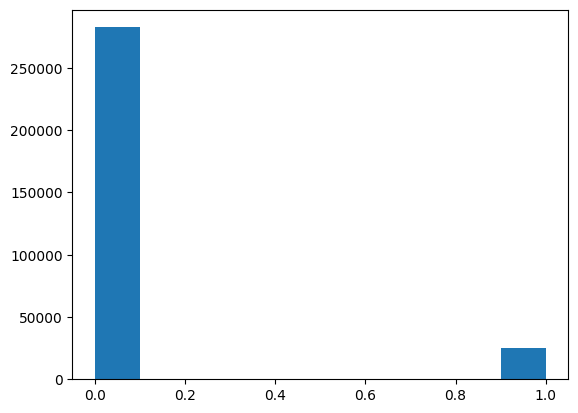

In [15]:
fig, ax = plt.subplots()

ax.hist(application_train['TARGET'])
plt.show()

We observe that this is an imbalanced class. A lot more loans have been reapaid con time than loans that were not repaid.

## Missing values

In [16]:
def missing_values_table(df):
    """
    Takes the dataframe and display missing values count and ratio
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Ratio of missing values
    mis_val_ratio = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_ratio], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by ratio of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [17]:
missing_values = missing_values_table(application_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [18]:
# get a list of columns with missing values
missing_columns = [col for col in application_train.columns if application_train[col].isnull().any()]

In [19]:
application_train[missing_columns].head()

,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,24700.5,351000.0,Unaccompanied,NaN,Laborers,1.0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,35698.5,1129500.0,Family,NaN,Core staff,2.0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6750.0,135000.0,Unaccompanied,26.0,Laborers,1.0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29686.5,297000.0,Unaccompanied,NaN,Laborers,2.0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,Unaccompanied,NaN,Core staff,1.0,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


## Columns type

In [20]:
# Number of each type of column
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [21]:
categorical_vars = application_train.select_dtypes(include='object').columns.tolist()
print(categorical_vars)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [22]:
quantitative_vars = application_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(quantitative_vars)

['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEAR

### Categorical variables

In [23]:
# Number of unique classes in each object column
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [24]:
application_train['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [25]:
application_train.loc[application_train['CODE_GENDER'] == 'XNA']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
35657,141289,0,Revolving loans,XNA,Y,Y,0,207000.0,382500.0,19125.0,337500.0,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,0.020713,-20232,-10044,-10024.0,-3537,13.0,1,1,1,1,1,0,NaN,2.0,3,3,TUESDAY,10,0,0,0,0,0,0,Business Entity Type 1,NaN,0.295998,0.461482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-286.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
38566,144669,0,Revolving loans,XNA,N,Y,2,157500.0,270000.0,13500.0,225000.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13717,-2797,-2241.0,-4659,NaN,1,1,1,1,1,0,Low-skill Laborers,4.0,2,2,FRIDAY,16,0,0,0,0,0,0,Industry: type 3,NaN,0.709205,0.310818,0.0165,0.0368,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0233,NaN,0.0115,NaN,0.0000,0.0168,0.0382,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0238,NaN,0.0120,NaN,0.0000,0.0167,0.0368,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0237,NaN,0.0117,NaN,0.000,NaN,block of flats,0.0090,"Stone, brick",No,0.0,0.0,0.0,0.0,-493.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,3.0,0.0,4.0
83382,196708,0,Revolving loans,XNA,N,Y,1,135000.0,405000.0,20250.0,225000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.035792,-10647,-1228,-183.0,-1671,NaN,1,1,1,1,1,0,Core staff,3.0,2,2,THURSDAY,15,0,0,0,0,0,0,Kindergarten,0.404970,0.659185,0.076984,0.0773,0.1353,0.9921,0.8912,NaN,0.0,0.1379,0.1667,0.0417,NaN,0.0630,0.0621,0.0000,NaN,0.0788,0.1404,0.9921,0.8955,NaN,0.0,0.1379,0.1667,0.0417,NaN,0.0689,0.0647,0.0000,NaN,0.0781,0.1353,0.9921,0.8927,NaN,0.0,0.1379,0.1667,0.0417,NaN,0.0641,0.0632,0.0000,NaN,reg oper spec account,block of flats,0.076

In [26]:
# drop rows with XNA
application_train = application_train[application_train['CODE_GENDER'] != 'XNA']

In [27]:
application_train['NAME_TYPE_SUITE'].unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', nan, 'Other_B', 'Group of people'], dtype=object)

In [28]:
application_train['EMERGENCYSTATE_MODE'].value_counts()

EMERGENCYSTATE_MODE
No     159425
Yes      2328
Name: count, dtype: int64

Get details on the variables

In [29]:
# Set the option to display full length of a column
pd.set_option('display.max_colwidth', None)
application_description[application_description['Row'].isin(categorical_vars)][["Row", "Description", "Special"]]

,Row,Description,Special
5,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,CODE_GENDER,Gender of the client,NaN
7,FLAG_OWN_CAR,Flag if the client owns a car,NaN
8,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
14,NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan,NaN
15,NAME_INCOME_TYPE,"Clients income type (businessman, working, maternity leave, )",NaN
16,NAME_EDUCATION_TYPE,Level of highest education the client achieved,NaN
17,NAME_FAMILY_STATUS,Family status of the client,NaN
18,NAME_HOUSING_TYPE,"What is the housing situation of the client (renting, living with parents, ...)",NaN
31,OCCUPATION_TYPE,What kind of occupation does the client have,NaN


In [30]:
application_description['Special'].unique()

array([nan, 'normalized ', 'time only relative to the application',
       'rounded', 'normalized'], dtype=object)

Except for ORGANIZATIO_TYPE then OCCUPATION_TYPE, categorical variables have a small amount of unique values.

#### Encoding

For categorical variables with 2 classes =>  0 and 1
For more than 2 classes => One Hot Encoding

In [31]:
# # Create the label encoder object
# le = LabelEncoder()
# le_count = 0

# # Iterate through the columns
# for col in application_train:
#     if application_train[col].dtype == "object":
#         # If 2 or fewer unique categories
#         if len(list(application_train[col].unique())) <= 2:
#             # Train on the training data
#             le.fit(application_train[col])
#             # Transform both training and testing data
#             application_train[col] = le.transform(application_train[col])
#             application_test[col] = le.transform(application_test[col])

#             # Keep track of how many columns were label encoded
#             le_count += 1

# print("%d columns were label encoded." % le_count)

# one-hot encoding of categorical variables
# application_train = pd.get_dummies(application_train)
# application_test = pd.get_dummies(application_test)

# print('Training Features shape: ', application_train.shape)
# print('Testing Features shape: ', application_test.shape)

### Quantitative variables

In [32]:
# Display the first 5 rows of the quantitative variables
application_train[quantitative_vars].head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,0.0149,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,0.0714,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [33]:
pd.set_option('display.max_rows', None)
application_description[application_description['Row'].isin(quantitative_vars)][["Row", "Description", "Special"]]

,Row,Description,Special
1,SK_ID_CURR,ID of loan in our sample,NaN
2,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
9,CNT_CHILDREN,Number of children the client has,NaN
10,AMT_INCOME_TOTAL,Income of the client,NaN
11,AMT_CREDIT,Credit amount of the loan,NaN
12,AMT_ANNUITY,Loan annuity,NaN
13,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given,NaN
19,REGION_POPULATION_RELATIVE,Normalized population of region where client lives (higher number means the client lives in more populated region),normalized
20,DAYS_BIRTH,Client's age in days at the time of application,time only relative to the application
21,DAYS_EMPLOYED,How many days before the application the person started current employment,time only relative to the application


## Outliers

In [34]:
not_flag_feature = [col for col in quantitative_vars if 'FLAG' not in col]
application_train[not_flag_feature].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307507.000000,307507.00000,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,104580.000000,307505.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,134131.000000,3.068470e+05,246542.000000,151447.000000,127565.000000,157501.000000,103021.000000,92645.000000,143617.000000,152680.000000,154488.000000,98867.000000,124919.000000,97310.000000,153158.000000,93995.000000,137827.000000,151447.000000,127565.000000,157501.000000,103021.000000,92645.000000,143617.000000,152680.000000,154488.000000,98867.000000,124919.000000,97310.000000,153158.000000,93995.000000,137827.000000,151447.000000,127565.000000,157501.000000,103021.000000,92645.000000,143617.000000,152680.000000,154488.000000,98867.000000,124919.000000,97310.000000,153158.000000,93995.000000,137827.000000,159077.000000,306486.000000,306486.000000,306486.000000,306486.000000,307506.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000
mean,278181.527256,0.08073,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,-16037.027271,63815.929208,-4986.131376,-2994.201670,12.061121,2.152658,2.052461,2.031518,12.063394,0.015144,0.050770,0.040659,0.078174,0.230457,0.179557,0.502129,5.143918e-01,0.510856,0.117442,0.088443,0.977735,0.752472,0.044621,0.078943,0.149726,0.226284,0.231897,0.066334,0.100776,0.107400,0.008809,0.028358,0.114232,0.087543,0.977065,0.759637,0.042554,0.074491,0.145194,0.222317,0.228061,0.064958,0.105646,0.105976,0.008077,0.027023,0.117851,0.087955,0.977752,0.755746,0.044596,0.078079,0.149214,0.225899,0.231628,0.067169,0.101956,0.108608,0.008651,0.028236,0.102548,1.422209,0.143406,1.405255,0.100034,-962.860546,0.006403,0.007000,0.034362,0.267388,0.265474,1.899950
std,102790.132982,0.27242,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,0.013831,4363.982424,141276.472519,3522.883030,1509.454566,11.944919,0.910680,0.509034,0.502737,3.265835,0.122127,0.219527,0.197500,0.268445,0.421126,0.383819,0.211063,1.910603e-01,0.194843,0.108241,0.082439,0.059224,0.113279,0.076036,0.134577,0.100050,0.144641,0.161380,0.081184,0.092577,0.110565,0.047732,0.069524,0.107937,0.084308,0.064576,0.110110,0.074445,0.132257,0.100978,0.143710,0.161160,0.081751,0.097881,0.111846,0.046277,0.070254,0.109076,0.082179,0.059898,0.112066,0.076145,0.134468,0.100369,0.145067,0.161934,0.082

### Days related variables

#### Age

In [35]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

#### Unemployement

In [36]:
application_train['DAYS_EMPLOYED'] .describe()

count    307507.000000
mean      63815.929208
std      141276.472519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

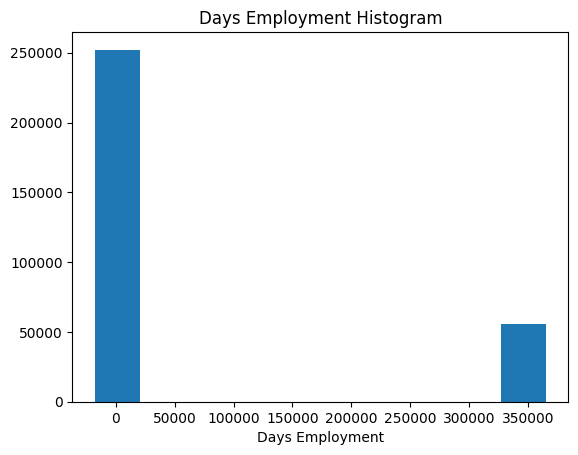

In [37]:
fig, ax = plt.subplots()

ax.hist(application_train['DAYS_EMPLOYED'])
ax.set_title('Days Employment Histogram')
ax.set_xlabel('Days Employment')
plt.show()

In [38]:
# Subset the extreme values and see if the target is different
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


How to correct these outliers ? Since we're missing business information on this, the safest way to deal with it is to replace with NaN and proceed to an imputation before the predictive model. Here, these outliers have the same value. Is there a link between all these rows? We'll keep a track of this information by adding a variable indicating wether or not this value was normal or not.

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_46202/1687167807.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


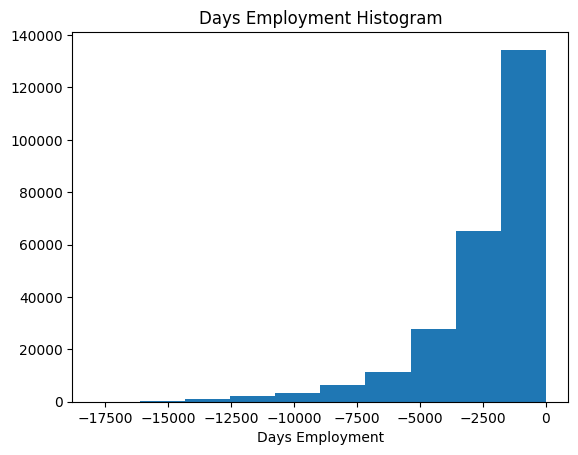

In [39]:
# Create an anomalous flag column
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

fig, ax = plt.subplots()
ax.hist(application_train['DAYS_EMPLOYED'])
ax.set_title('Days Employment Histogram')
ax.set_xlabel('Days Employment')

plt.show()

In [40]:
application_train[quantitative_vars].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307507.000000,307507.00000,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,252133.000000,307507.000000,307507.000000,104580.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307505.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,134131.000000,3.068470e+05,246542.000000,151447.000000,127565.000000,157501.000000,103021.000000,92645.000000,143617.000000,152680.000000,154488.000000,98867.000000,124919.000000,97310.000000,153158.000000,93995.000000,137827.000000,151447.000000,127565.000000,157501.000000,103021.000000,92645.000000,143617.000000,152680.000000,154488.000000,98867.000000,124919.000000,97310.000000,153158.000000,93995.000000,137827.000000,151447.000000,127565.000000,157501.000000,103021.000000,92645.000000,143617.000000,152680.000000,154488.000000,98867.000000,124919.000000,97310.000000,153158.000000,93995.000000,137827.000000,159077.000000,306486.000000,306486.000000,306486.000000,306486.000000,307506.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.00000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000
mean,278181.527256,0.08073,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,-16037.027271,-2384.142254,-4986.131376,-2994.201670,12.061121,0.999997,0.819887,0.199358,0.998133,0.281057,0.056721,2.152658,2.052461,2.031518,12.063394,0.015144,0.050770,0.040659,0.078174,0.230457,0.179557,0.502129,5.143918e-01,0.510856,0.117442,0.088443,0.977735,0.752472,0.044621,0.078943,0.149726,0.226284,0.231897,0.066334,0.100776,0.107400,0.008809,0.028358,0.114232,0.087543,0.977065,0.759637,0.042554,0.074491,0.145194,0.222317,0.228061,0.064958,0.105646,0.105976,0.008077,0.027023,0.117851,0.087955,0.97

## Correlations with target

In [41]:
correlations = application_train[quantitative_vars].corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032261
LIVE_CITY_NOT_WORK_CITY        0.032517
OWN_CAR_AGE                    0.037611
DAYS_REGISTRATION              0.041976
FLAG_DOCUMENT_3                0.044341
REG_CITY_NOT_LIVE_CITY         0.044394
FLAG_EMP_PHONE                 0.045984
REG_CITY_NOT_WORK_CITY         0.050992
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055219
REGION_RATING_CLIENT           0.058901
REGION_RATING_CLIENT_W_CITY    0.060895
DAYS_EMPLOYED                  0.074957
DAYS_BIRTH                     0.078242
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178926
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044009
FLOORSMAX_MEDI               -0.043773
FLOORSMAX_MODE               -0.043231
AMT_GOODS_PRICE              -0.039647
REGION_POPULATION_RELATIVE   -0.037225


### The age

The age seems to me the most correlated variable. It is expressed in days and is negative. For better understanding, let's take the absolute value.

In [42]:
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

np.float64(-0.07824216003619376)

The trend of repaying a loans grows with the client age. 

Let's understand the repartition of clients age in ur dataset

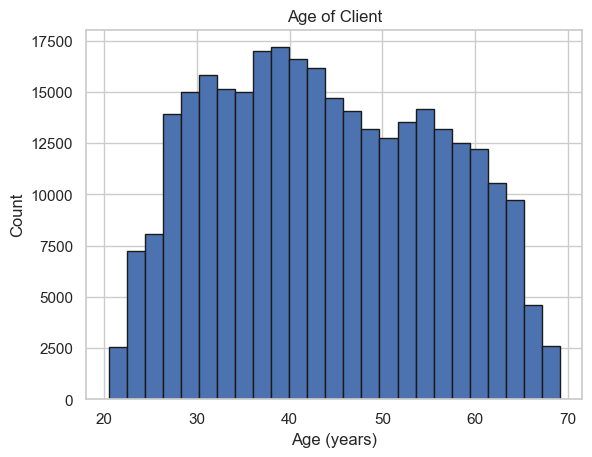

In [43]:
# set seaborn grid style
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots()

ax.hist(application_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)

ax.set_title('Age of Client')
ax.set_xlabel('Age (years)')
ax.set_ylabel('Count')

plt.show()

No outliers and ages are in a reasonable range.

Using KDE to visualie the effect of the age on the target.

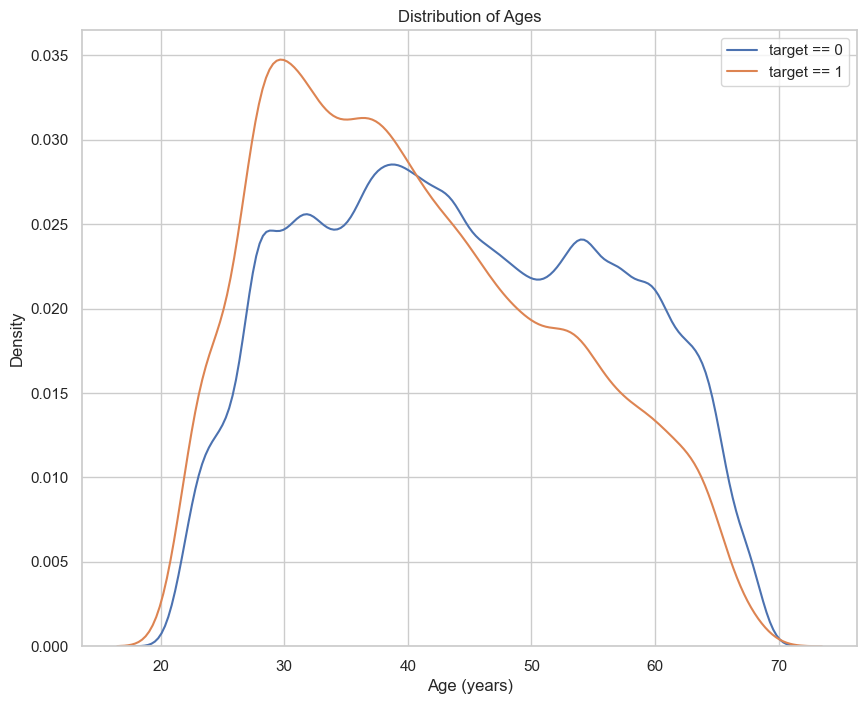

In [44]:
# Kernel density estimation
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Ages')

plt.show()

Even though the correlation coefficient is low, we notice that the curve is skewed toward the younger end of the range for target == 1.

Let's understand the the average failure to repay a loan by age brackets.

In [45]:
# Age information into a separate dataframe
age_data = application_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Cut the age into bins of 5 years each
age_data['YEARS_BINNED'] = pd.cut(age_data['DAYS_BIRTH'] / 365, bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_46202/1512388715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_46202/1512388715.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['DAYS_BIRTH'] / 365, bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [46]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_46202/1757995694.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups  = age_data.groupby('YEARS_BINNED').mean()


,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111442,10155.219690,27.822520
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089416,13707.908041,37.555912
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055316,20984.285455,57.491193
"(60.0, 65.0]",0.052737,22780.547460,62.412459


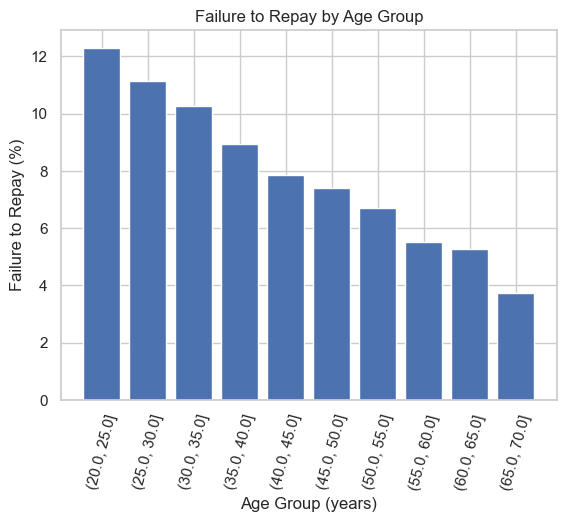

In [47]:
fig, ax = plt.subplots()

ax.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

ax.set_title('Failure to Repay by Age Group')
ax.set_xlabel('Age Group (years)')
ax.set_ylabel('Failure to Repay (%)')
# rotate x ticks
plt.xticks(rotation = 75)

plt.show()

We can clearly observe the trend that youngers are more likely to not repay their loan

### External ressources

External csources are the most negavely correlated to the target. What are those ?

In [48]:
# According to the documentation
application_description[application_description['Row'].isin(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])][["Row", "Description", "Special"]]

,Row,Description,Special
44,EXT_SOURCE_1,Normalized score from external data source,normalized
45,EXT_SOURCE_2,Normalized score from external data source,normalized
46,EXT_SOURCE_3,Normalized score from external data source,normalized


Doesn't give much information. How do they play around the target and other correlated variable ?

Text(0.5, 1.0, 'Correlation Heatmap')

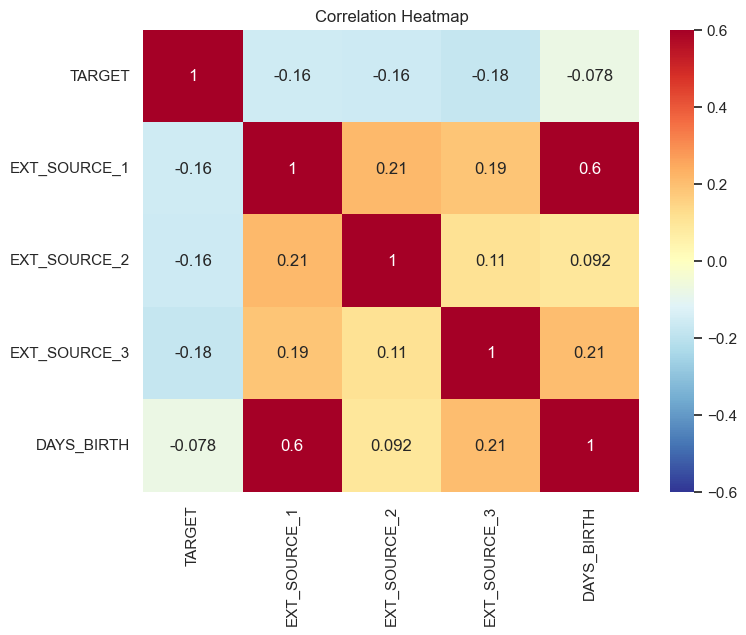

In [49]:
# get correlation of the EXT_SOURCE features with the target and plot them
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

plt.figure(figsize = (8, 6))
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.6, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

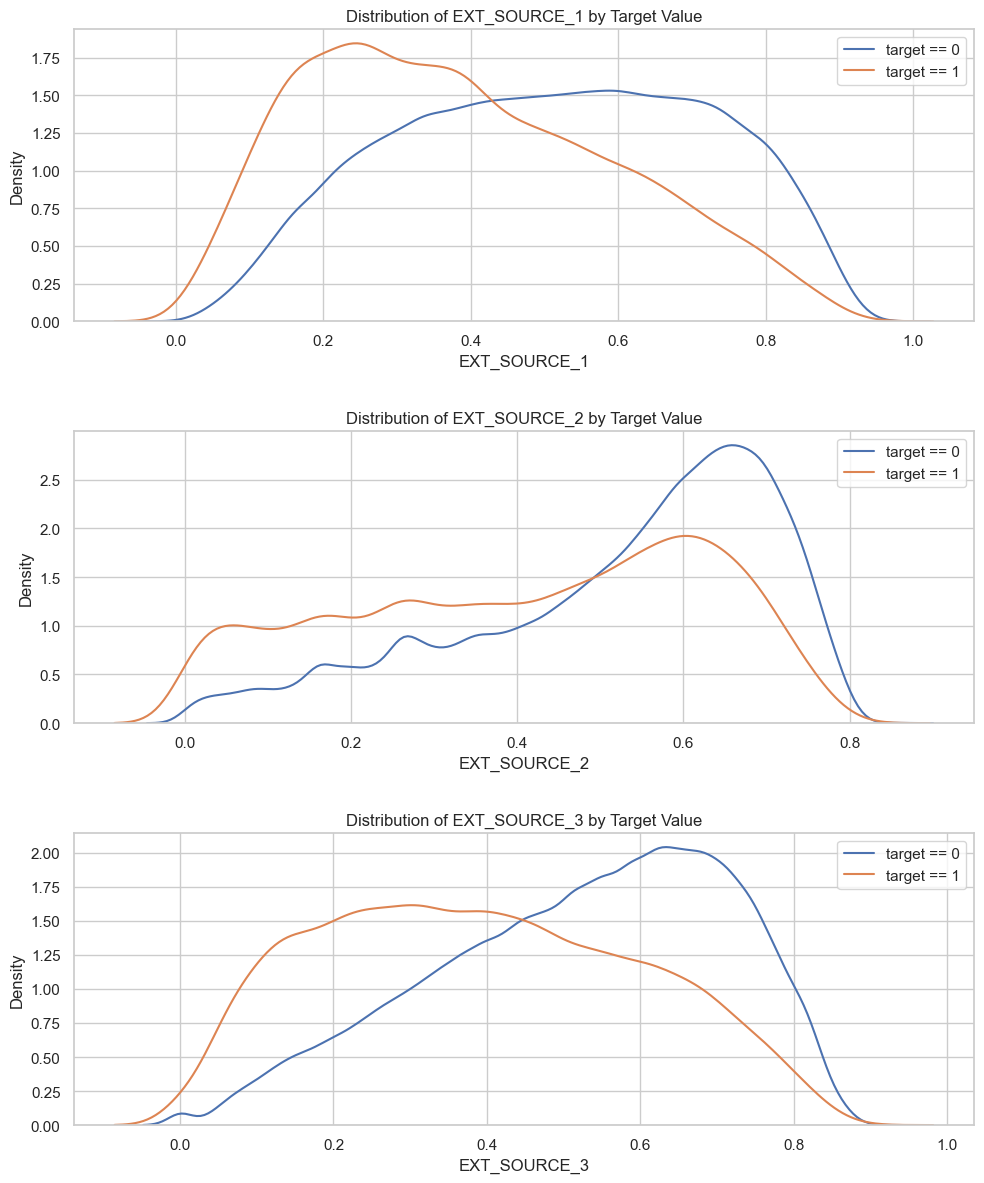

In [50]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density')
    plt.legend()

plt.tight_layout(h_pad = 2.5)

# Features engineering

##  Simple new features 

In [51]:
app_train_domain = application_train.copy()

# Ratio of credit amount compared to income
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
# Ratio of annuity amount compared to income
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
# Ratio of credit amount compared to annuity amount
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
# The ratio of days work in a life
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [ ]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Density')
    plt.legend()

    plt.show()

# Split the code in train and test data

In [85]:
from sklearn.model_selection import train_test_split

X = application_train.drop(columns=["SK_ID_CURR", "TARGET"])
y = application_train['TARGET']

# Utiliser sample (with stratify)
# Split the cv method
# check logreg et rfc pour features importance
# check stability of samples

# Split into training and validation set
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train_full.shape)

# Create a smaller subset to improve speed
X_sub, _, y_sub, _ = train_test_split(
    X_train_full, y_train_full, test_size=0.7, random_state=42, stratify=y_train_full
)

# Create a smaller dataset from the training set for faster experiments
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_sub, y_sub, test_size=0.3, random_state=42, stratify=y_sub
)
print(X_train_small.shape, X_test_small.shape)

# For testing a change of random state
# X_train_rand, _, y_train_rand, _ = train_test_split(
#     X_sub, y_sub, test_size=0.3, random_state=19, stratify=y_sub
# )

(246005, 121)
(51660, 121) (22141, 121)


In [152]:
# For testing a change of random state
X_train_rand, _, y_train_rand, _ = train_test_split(
    X_sub, y_sub, test_size=0.3, random_state=19, stratify=y_sub
)


# Preprocessing

## Imputation, Scaling & Encoding

In [110]:
# Create lists to hold columns that will be one-hot encoded and label encoded
bimodal_cols = []
multimodal_cols = []
# Iterate through the columns
for col in X_train_small:
    if X_train_small[col].dtype == "object":
        # If 2 or fewer unique categories
        bimodal_cols.append(col) if len(
            list(X_train_small[col].unique())
        ) <= 2 else multimodal_cols.append(col)

print("%d columns to process with a label encoder." % len(bimodal_cols))
print(bimodal_cols)
print("%d columns to process with a one-hot encoder." % len(multimodal_cols))
print(multimodal_cols)

4 columns to process with a label encoder.
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
12 columns to process with a one-hot encoder.
['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [111]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
)

from sklearn import set_config

set_config(display="diagram")

num_imputer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),])

ordinal_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder()),
    ]
)

one_hot_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# the argument 'reminder' defines the processing of the columns not specified in the transformers. 'passthrough' means that they will be left unchanged, otherwise they will be dropped
col_processor = ColumnTransformer(
    transformers=[
        ("num", num_imputer, make_column_selector(dtype_include=np.number)),
        ("ordinal", ordinal_pipeline, bimodal_cols),
        ("one_hot", one_hot_pipeline, multimodal_cols),
    ],
    remainder="passthrough",
)


### Pipeline

In [162]:
from imblearn.pipeline import Pipeline as imbPipeline
set_config(display="diagram")

def create_pipeline(model, resampling_strategy=None):
    """Creates a pipeline with the specified model and resampling strategy"""
    steps = [("preprocessor", col_processor), ("sacler",MinMaxScaler()), ("model", model)]
    if resampling_strategy:
        if isinstance(resampling_strategy, list):
            steps.insert(2,("resampling1", resampling_strategy[0]))
            steps.insert(3,("resampling2", resampling_strategy[1]))
        else:
            steps.insert(2,("resampling", resampling_strategy))
        return imbPipeline(steps=steps)
    else:
        return Pipeline(steps=steps)

def shape_after_resampling(X, y, pipeline):
    """Defines the shape of the dataset after resampling"""
    pipeline_up_to_sampling = imbPipeline(pipeline.steps[:-1])  # Exclude the classifier
    X_transformed, y_transformed = pipeline_up_to_sampling.fit_resample(X, y)
    return X_transformed.shape

# Modelisation

## Scoring

In [89]:
from sklearn.metrics import confusion_matrix, make_scorer


def cost_score(y_true, y_pred):
    """Custom scoring method to add a cost to false negatives

    Args:
        y_true (Series): TARGET
        y_pred (Series): predicted values

    Returns:
        int: score
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # precision = 0 if tp + fp == 0 else (tp / (tp + fp))
    # Penalize false negatives by a factor of 10
    weighted_recall = tp / (tp + (10 * fn))

    return weighted_recall

# Create a scorer object that will be used instead of the default scoring metrics in sklearn
custom_scorer = make_scorer(cost_score, greater_is_better=True)

## Models perf

In [90]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))

    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues"
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")

    # Afficher la figure
    plt.show()


In [149]:
# Creat a dataframe that will store the results
results = pd.DataFrame(
    columns=[
        "Shape",
        "Model",
        "Sampling_strategy",
        "Accuracy",
        "precision",
        "recall",
        "Custom_recall",
        "ROC_AUC",
    ]
)


In [185]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

set_config(display="diagram")

def cv_custom_metric(model, X_train, y_train, fk, sampling_strategy=None, df=None):
    """
    Makes a cross-validation of a model and stores the results in a DataFrame
    args:
        X (Dataframe) : features
        y (Series) : target
        model (estimator) : model to train or pipeline
        balance_technique (str) : technique to balance the data
        folds (int) : number of folds for cross-validation
    return:
        results : DataFrame with the results
    """

    model_name = model.__class__.__name__

    pipe = create_pipeline(model, sampling_strategy)

    if sampling_strategy:
        shape = shape_after_resampling(X_train, y_train, pipe)
    else:
        shape = X_train.shape

    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score),
        "custom_recall": make_scorer(cost_score, greater_is_better=True),
        "roc_auc": make_scorer(roc_auc_score),
    }
    # Train and predict the model
    cv = cross_validate(pipe, X_train, y_train, cv=fk, scoring=scoring, return_estimator=True)

    # Evaluate features
    importance_list = []
    for model in cv['estimator']:
        importance_list.append(model.feature_importances_)
    # feature_importance=feature_importance(pipe, X_train, y_train)
    # if model_name == "LogisticRegression":
    #     for model in cv['estimator']:
    #         importance_list.append(model.coef_)
    # if model_name in ["LGBMClassifier", "XGBClassifier"]:
    #     for model in cv['estimator']:
    #         importance_list.append(model.feature_importances_)

    # Calculate metrics
    metrics = {
        "Shape": shape,
        "Model": model_name,
        "Sampling strategy": sampling_strategy,
        "Fit time": cv["fit_time"].mean(),
        "Accuracy": round(cv["test_accuracy"].mean(),3),
        "Precision": round(cv["test_precision"].mean(),3),
        "Recall": round(cv["test_recall"].mean(),3),
        "ROC AUC": round(cv["test_roc_auc"].mean(),3),
        "Custom Recall": round(cv["test_custom_recall"].mean(),3),
        "Importance": importance_list
    }


    metrics_df = pd.DataFrame([metrics])

    # Initialize results if it is None
    if df is None:
        df = pd.DataFrame()

    # Check if results DataFrame is empty or contains only NA values
    if df.empty or df.isna().all().all():
        df = metrics_df
    else:
        df = pd.concat([df, metrics_df], ignore_index=True)

    return df


# Testing models

In [151]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display

# Instanciate the stratified kfold object in order to keep the same proportion of target in each fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
simple_models = [DummyClassifier(strategy="most_frequent"), LogisticRegression()]
results = None
for model in simple_models:
    results = cv_custom_metric(
        model,
        X_train_small,
        y_train_small,
        kf,
        df=results,
    )

display(results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

,Shape,Model,Sampling strategy,Fit time,Accuracy,Precision,Recall,ROC AUC,Custom Recall
0,"(51660, 121)",DummyClassifier,None,0.511966,0.919,0.000,0.000,0.500,0.000
1,"(51660, 121)",LogisticRegression,None,1.497575,0.919,0.447,0.012,0.505,0.001


With a dummy classifier, our accuracy is excellent. However, using the most frequent strategy, we expect the classifier to predict 100% of the most frequen classe, here 0, meaning 'goog client'.

In the confusion matrix, none of data predicted were 0, so number of TP = 0 and recall = 0

We can notice that the model doesn't predict any dangerous clients. Probably due to our very imbalanced dataset. What happens if we work on that ?

## Test the stability of the model

### Changing random state

In [155]:
results = cv_custom_metric(LogisticRegression(),X_train_rand, y_train_rand, kf, df=results)
display(results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

,Shape,Model,Sampling strategy,Fit time,Accuracy,Precision,Recall,ROC AUC,Custom Recall
0,"(51660, 121)",DummyClassifier,None,0.511966,0.919,0.000,0.000,0.500,0.000
1,"(51660, 121)",LogisticRegression,None,1.497575,0.919,0.447,0.012,0.505,0.001
2,"(51660, 121)",LogisticRegression,None,1.605619,0.919,0.449,0.011,0.505,0.001


The fact of changing the random state when we split our data doesnt't affect the results. 
Let's check if using more data could give a better result.

In [156]:
results = cv_custom_metric(
    LogisticRegression(), X_train_full, y_train_full, kf, df=results
)
display(results)


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

,Shape,Model,Sampling strategy,Fit time,Accuracy,Precision,Recall,ROC AUC,Custom Recall
0,"(51660, 121)",DummyClassifier,None,0.511966,0.919,0.000,0.000,0.500,0.000
1,"(51660, 121)",LogisticRegression,None,1.497575,0.919,0.447,0.012,0.505,0.001
2,"(51660, 121)",LogisticRegression,None,1.605619,0.919,0.449,0.011,0.505,0.001
3,"(246005, 121)",LogisticRegression,None,7.128505,0.919,0.461,0.011,0.505,0.001


We get the same results for a training time more important. In conclusion, we will continue to work on a subset for computing performance.

## Balancing the dataset

We saw earlier that we are dealing with an imbalanced dataset. As for our first results, we observed that the model is highly impacted by this and has a tendency to predict in favor of the majority class.

In this part, we will analyse the impact of few sampling strategies on the results. To do so, we are going to use the Imblearn module.

## Using imblearn module

In [159]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import TomekLinks


rus = RandomUnderSampler(random_state=42, replacement=True)
ros = RandomOverSampler(random_state=42)
tl = TomekLinks(sampling_strategy="majority")
smote = SMOTE()
nm = NearMiss()

sampling_stategies = [rus, ros, tl, smote, nm]
for strategy in sampling_stategies:
    results = cv_custom_metric(
        LogisticRegression(), X_train_small, y_train_small, kf, df=results, sampling_strategy=strategy
    )


display(results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

,Shape,Model,Sampling strategy,Fit time,Accuracy,Precision,Recall,ROC AUC,Custom Recall
0,"(51660, 121)",DummyClassifier,None,0.511966,0.919,0.000,0.000,0.500,0.000
1,"(51660, 121)",LogisticRegression,None,1.497575,0.919,0.447,0.012,0.505,0.001
2,"(51660, 121)",LogisticRegression,None,1.605619,0.919,0.449,0.011,0.505,0.001
3,"(246005, 121)",LogisticRegression,None,7.128505,0.919,0.461,0.011,0.505,0.001
4,"(8342, 239)",LogisticRegression,"RandomUnderSampler(random_state=42, replacement=True)",0.650451,0.678,0.154,0.664,0.672,0.166
5,"(94978, 239)",LogisticRegression,RandomOverSampler(random_state=42),3.014244,0.687,0.158,0.664,0.676,0.165
6,"(50536, 239)",LogisticRegression,TomekLinks(sampling_strategy='majority'),6.359673,0.919,0.438,0.013,0.506,0.001
7,"(94978, 239)",LogisticRegression,SMOTE(),3.322610,0.697,0.157,0.631,0.667,0.147
8,"(8342, 239)",LogisticRegression,NearMiss(),1.163309,0.238,0.087,0.885,0.533,0.436


## Combining SMOTE & Nearmiss

In [163]:
results = cv_custom_metric(
    LogisticRegression(),
    X_train_small,
    y_train_small,
    kf,
    df=results,
    sampling_strategy=[smote,nm],
)
display(results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

,Shape,Model,Sampling strategy,Fit time,Accuracy,Precision,Recall,ROC AUC,Custom Recall
0,"(51660, 121)",DummyClassifier,None,0.511966,0.919,0.000,0.000,0.500,0.000
1,"(51660, 121)",LogisticRegression,None,1.497575,0.919,0.447,0.012,0.505,0.001
2,"(51660, 121)",LogisticRegression,None,1.605619,0.919,0.449,0.011,0.505,0.001
3,"(246005, 121)",LogisticRegression,None,7.128505,0.919,0.461,0.011,0.505,0.001
4,"(8342, 239)",LogisticRegression,"RandomUnderSampler(random_state=42, replacement=True)",0.650451,0.678,0.154,0.664,0.672,0.166
5,"(94978, 239)",LogisticRegression,RandomOverSampler(random_state=42),3.014244,0.687,0.158,0.664,0.676,0.165
6,"(50536, 239)",LogisticRegression,TomekLinks(sampling_strategy='majority'),6.359673,0.919,0.438,0.013,0.506,0.001
7,"(94978, 239)",LogisticRegression,SMOTE(),3.322610,0.697,0.157,0.631,0.667,0.147
8,"(8342, 239)",LogisticRegression,NearMiss(),1.163309,0.238,0.087,0.885,0.533,0.436
9,"(94978, 239)",LogisticRegression,"[SMOTE(), NearMiss()]",7.008803,0.696,0.157,0.632,0.667,0.147


Near miss strategy seems to give good results but accuracy is quite low...

TomekLinks has a good accuracy but doesn't seem to perform on the metric the most important to our case : recall.

Oversampling methods seem to have results that could be improved with a different model and a good hyperparameter tuning.

# Ensemble models

## Bagging models

In [186]:
from sklearn.ensemble import RandomForestClassifier

results = None
for model in [LogisticRegression(), RandomForestClassifier()]:
    results = cv_custom_metric(
        model, X_train_small, y_train_small, kf, df=results, sampling_strategy=smote
    )
display(results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

## Boosting techniques

In [169]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(learning_rate=1)

results = cv_custom_metric(model, X_train_small, y_train_small, kf, df=results, sampling_strategy=smote)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scor

In [170]:
display(results)

,Shape,Model,Sampling strategy,Fit time,Accuracy,Precision,Recall,ROC AUC,Custom Recall
0,"(94978, 239)",LogisticRegression,SMOTE(),3.042699,0.696,0.157,0.634,0.668,0.148
1,"(94978, 239)",DecisionTreeClassifier,SMOTE(),4.529883,0.834,0.123,0.172,0.533,0.020
2,"(94978, 239)",RandomForestClassifier,SMOTE(),21.608113,0.917,0.220,0.012,0.504,0.001
3,"(51660, 121)",XGBClassifier,None,1.216480,0.917,0.345,0.035,0.514,0.004
4,"(94978, 239)",AdaBoostClassifier,SMOTE(),22.570741,0.862,0.180,0.199,0.559,0.024


In [174]:
import xgboost as xgb
from xgboost import XGBClassifier

# To balance the dataset, we will use the scale_pos_weight parameter.
# If we set it to a value greater than 1, the model will give more importance to the positive class,
# as it will be penalized more for misclassifying this class.
# To set its value, we'll divide the number of negative samples by the number of positive ones.
ratio = float(y_train_small.value_counts()[0]) / y_train_small.value_counts()[1]
results = cv_custom_metric(XGBClassifier(scale_pos_parameter=ratio), X_train_small, y_train_small, kf, df=results, sampling_strategy=None)
display(results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:28:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_parameter" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:28:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_parameter" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:28:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_parameter" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib

,Shape,Model,Sampling strategy,Fit time,Accuracy,Precision,Recall,ROC AUC,Custom Recall
0,"(94978, 239)",LogisticRegression,SMOTE(),3.042699,0.696,0.157,0.634,0.668,0.148
1,"(94978, 239)",DecisionTreeClassifier,SMOTE(),4.529883,0.834,0.123,0.172,0.533,0.020
2,"(94978, 239)",RandomForestClassifier,SMOTE(),21.608113,0.917,0.220,0.012,0.504,0.001
3,"(51660, 121)",XGBClassifier,None,1.216480,0.917,0.345,0.035,0.514,0.004
4,"(94978, 239)",AdaBoostClassifier,SMOTE(),22.570741,0.862,0.180,0.199,0.559,0.024
5,"(51660, 121)",XGBClassifier,None,1.316580,0.917,0.345,0.035,0.514,0.004


In [176]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(scale_pos_weight=ratio)

results = cv_custom_metric(model, X_train_small, y_train_small, kf, df=results, sampling_strategy=None)
display(results)

[LightGBM] [Info] Number of positive: 3754, number of negative: 42740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10873
[LightGBM] [Info] Number of data points in the train set: 46494, number of used features: 221
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080742 -> initscore=-2.432313
[LightGBM] [Info] Start training from score -2.432313
[LightGBM] [Info] Number of positive: 3754, number of negative: 42740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10893
[LightGBM] [Info] Number of data points in the train set: 46494, number of used features: 220
[LightGBM] [Info

,Shape,Model,Sampling strategy,Fit time,Accuracy,Precision,Recall,ROC AUC,Custom Recall
0,"(94978, 239)",LogisticRegression,SMOTE(),3.042699,0.696,0.157,0.634,0.668,0.148
1,"(94978, 239)",DecisionTreeClassifier,SMOTE(),4.529883,0.834,0.123,0.172,0.533,0.020
2,"(94978, 239)",RandomForestClassifier,SMOTE(),21.608113,0.917,0.220,0.012,0.504,0.001
3,"(51660, 121)",XGBClassifier,None,1.216480,0.917,0.345,0.035,0.514,0.004
4,"(94978, 239)",AdaBoostClassifier,SMOTE(),22.570741,0.862,0.180,0.199,0.559,0.024
5,"(51660, 121)",XGBClassifier,None,1.316580,0.917,0.345,0.035,0.514,0.004
6,"(51660, 121)",LGBMClassifier,None,1.411822,0.737,0.173,0.594,0.672,0.128


Logistic Regression and Light GBM seem to be the most performing models.
Accuracy is not at the best but ROC-AUC does a little better than
a random model, as well as the custom recall.

# Features importance

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
    """

    # Sort features according to importance
    df = df.sort_values("importance", ascending=False).reset_index()

    # Normalize the feature importances to add up to one
    df["importance_normalized"] = df["importance"] / df["importance"].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(
        list(reversed(list(df.index[:15]))),
        df["importance_normalized"].head(15),
        align="center",
        edgecolor="k",
    )

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df["feature"].head(15))

    # Plot labeling
    plt.xlabel("Normalized Importance")
    plt.title("Feature Importances")
    plt.show()

    return df


In [ ]:
feature_importances = plot_feature_importances()